In [1]:
import glob
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import MyUtilities as utils
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
def get_camera_calibration(path):
    """Compute camera calibration parameters from a set of calibration images.

    Params:
      path: Directory of calibration images.
      
    Return:
      mtx, dist
    """
    #shape of chessboard.
    cshape = (9,6)
    
    # define arrays to get object and image points collections.
    objpoints = [] #3D points in real world image
    imgpoints = [] #2D points in image plane

    # Calibration points from images.
    filenames = os.listdir(path)
    for fname in filenames:
        img = cv2.imread(path + fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0), ... , (8,5,0)
        objp = np.zeros((cshape[0] * cshape[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:cshape[0], 0:cshape[1]].T.reshape(-1, 2)
        
        # get corners in the image.
        ret, corners = cv2.findChessboardCorners(gray, cshape, None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print('No chessboard corners found in..', fname)
    # Calibration from image points.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                       imgpoints,
                                                       img.shape[0:2],
                                                       None, None)
    return mtx, dist

def undistort_image(img, mtx, dist):
    """Undistort an image.
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

In [3]:
path = 'camera_cal/'
mtx, dist = get_camera_calibration(path)

No chessboard corners found in.. calibration1.jpg
No chessboard corners found in.. calibration4.jpg
No chessboard corners found in.. calibration5.jpg


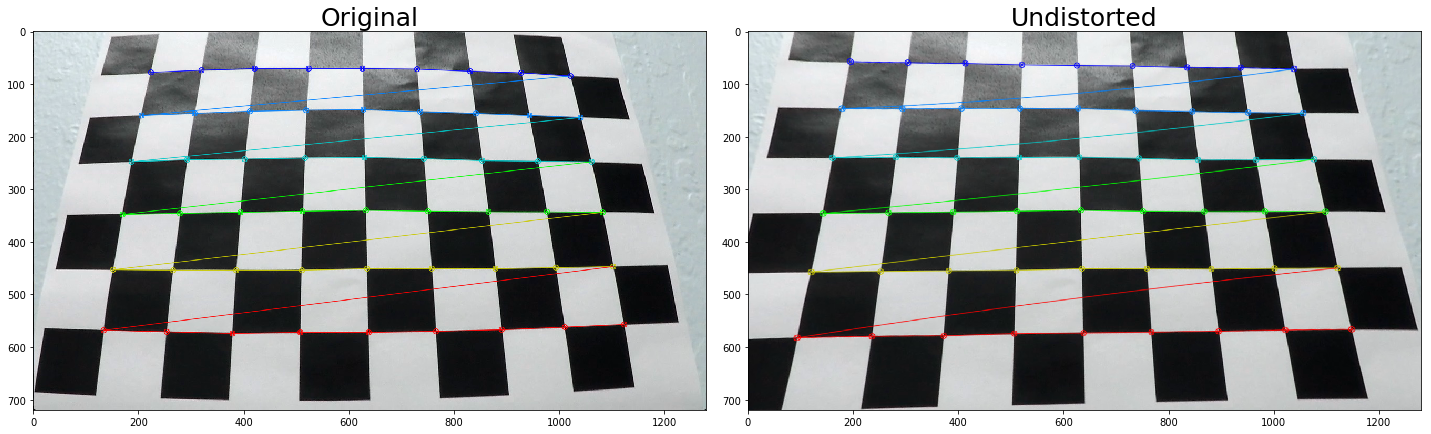

In [4]:
# test undistortion on an image
filenames = os.listdir(path)
fname = path + filenames[13]
img = cv2.imread(fname)
ret, corners = cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                                         (9,6), None)
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
undst = undistort_image(img, mtx, dist)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=25)
ax2.imshow(undst)
ax2.set_title('Undistorted', fontsize=25)

In [5]:
def perspective_transform(src, dst):
    """perspective transform from source and destination points.
    """
    perp_matrix = cv2.getPerspectiveTransform(src, dst)
    perp_matrix_inv = cv2.getPerspectiveTransform(dst, src)
    return perp_matrix, perp_matrix_inv

def warp_image(img, perp_matrix, flags=cv2.INTER_LINEAR):
    """Warp an image using a transform matrix.
    """
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, perp_matrix, img_size, flags=cv2.INTER_LINEAR)

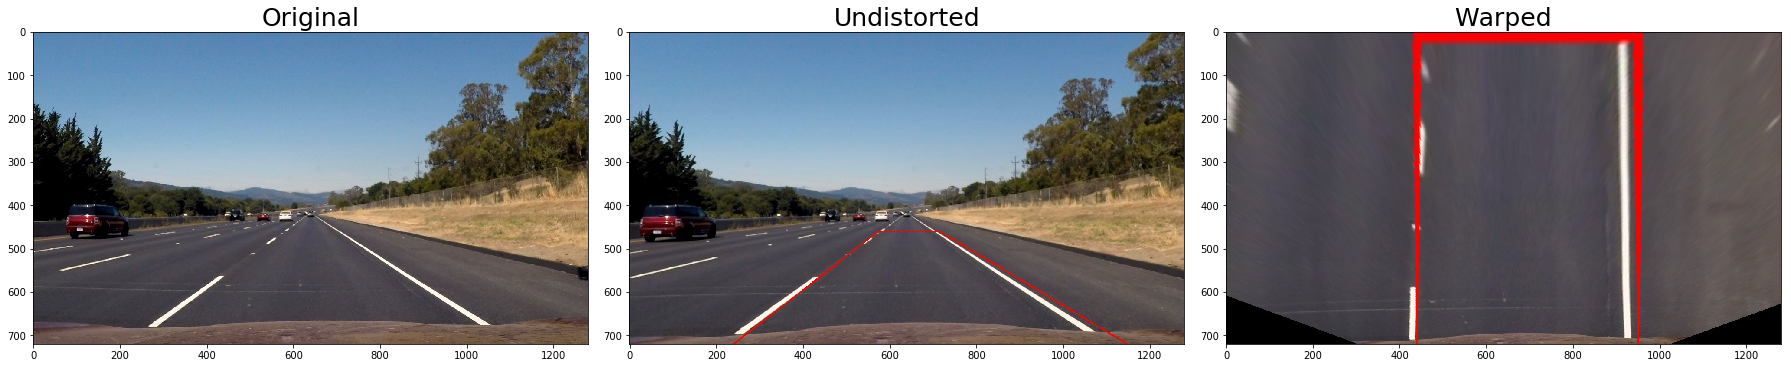

In [6]:
#source and destination points for perspective transform
src_points =  np.float32([[240., 720.], [ 575., 460.], [ 715., 460.], [ 1150., 720.]])
dst_points =  np.float32([[440., 720.], [ 440., 0.], [ 950., 0.], [ 950., 720.]])
perp_matrix, perp_matrix_inv = perspective_transform(src_points, dst_points)

#test perspective transform on an image
path = 'test_images/'
filenames = os.listdir(path)
fname = path + filenames[5]
img = mpimg.imread(fname)

#first undistort
undst = undistort_image(img, mtx, dist)
num_lines = len(src_points)
lines = [[[src_points[i][0],
           src_points[i][1],
           src_points[(i+1) % num_lines][0],
           src_points[(i+1) % num_lines][1]]] for i in range(num_lines)]

utils.draw_lines(undst, lines)
#then warp
warped_img = warp_image(undst, perp_matrix, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 15))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=25)
ax2.imshow(undst)
ax2.set_title('Undistorted', fontsize=25)
ax3.imshow(warped_img)
ax3.set_title('Warped', fontsize=25)

In [7]:
#Most of the codes are taken from the lecture notes...

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(gradmag)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_direction = np.arctan2(abs_sobely, abs_sobelx) 
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(abs_grad_direction)
    binary_output[(abs_grad_direction >= thresh[0]) & (abs_grad_direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select_s(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    # 3) Return a binary image of threshold result
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select_l(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(l_channel)
    # 3) Return a binary image of threshold result
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the V-channel of HSV
# Use exclusive lower bound (>) and inclusive upper (<=)
def hsv_select_v(img, thresh=(0, 255)):
    # 1) Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    # 2) Apply a threshold to the V channel
    binary_output = np.zeros_like(v_channel)
    # 3) Return a binary image of threshold result
    binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the B-channel of Lab 
# Use exclusive lower bound (>) and inclusive upper (<=)
def Lab_select_b(img, thresh=(0, 255)):
    # 1) Convert to Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(b_channel) > 175:
        b_channel = b_channel*(255/np.max(b_channel))
    # 2) Apply a threshold to the b channel
    binary_output = np.zeros_like(b_channel)
    # 3) Return a binary image of threshold result
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_output

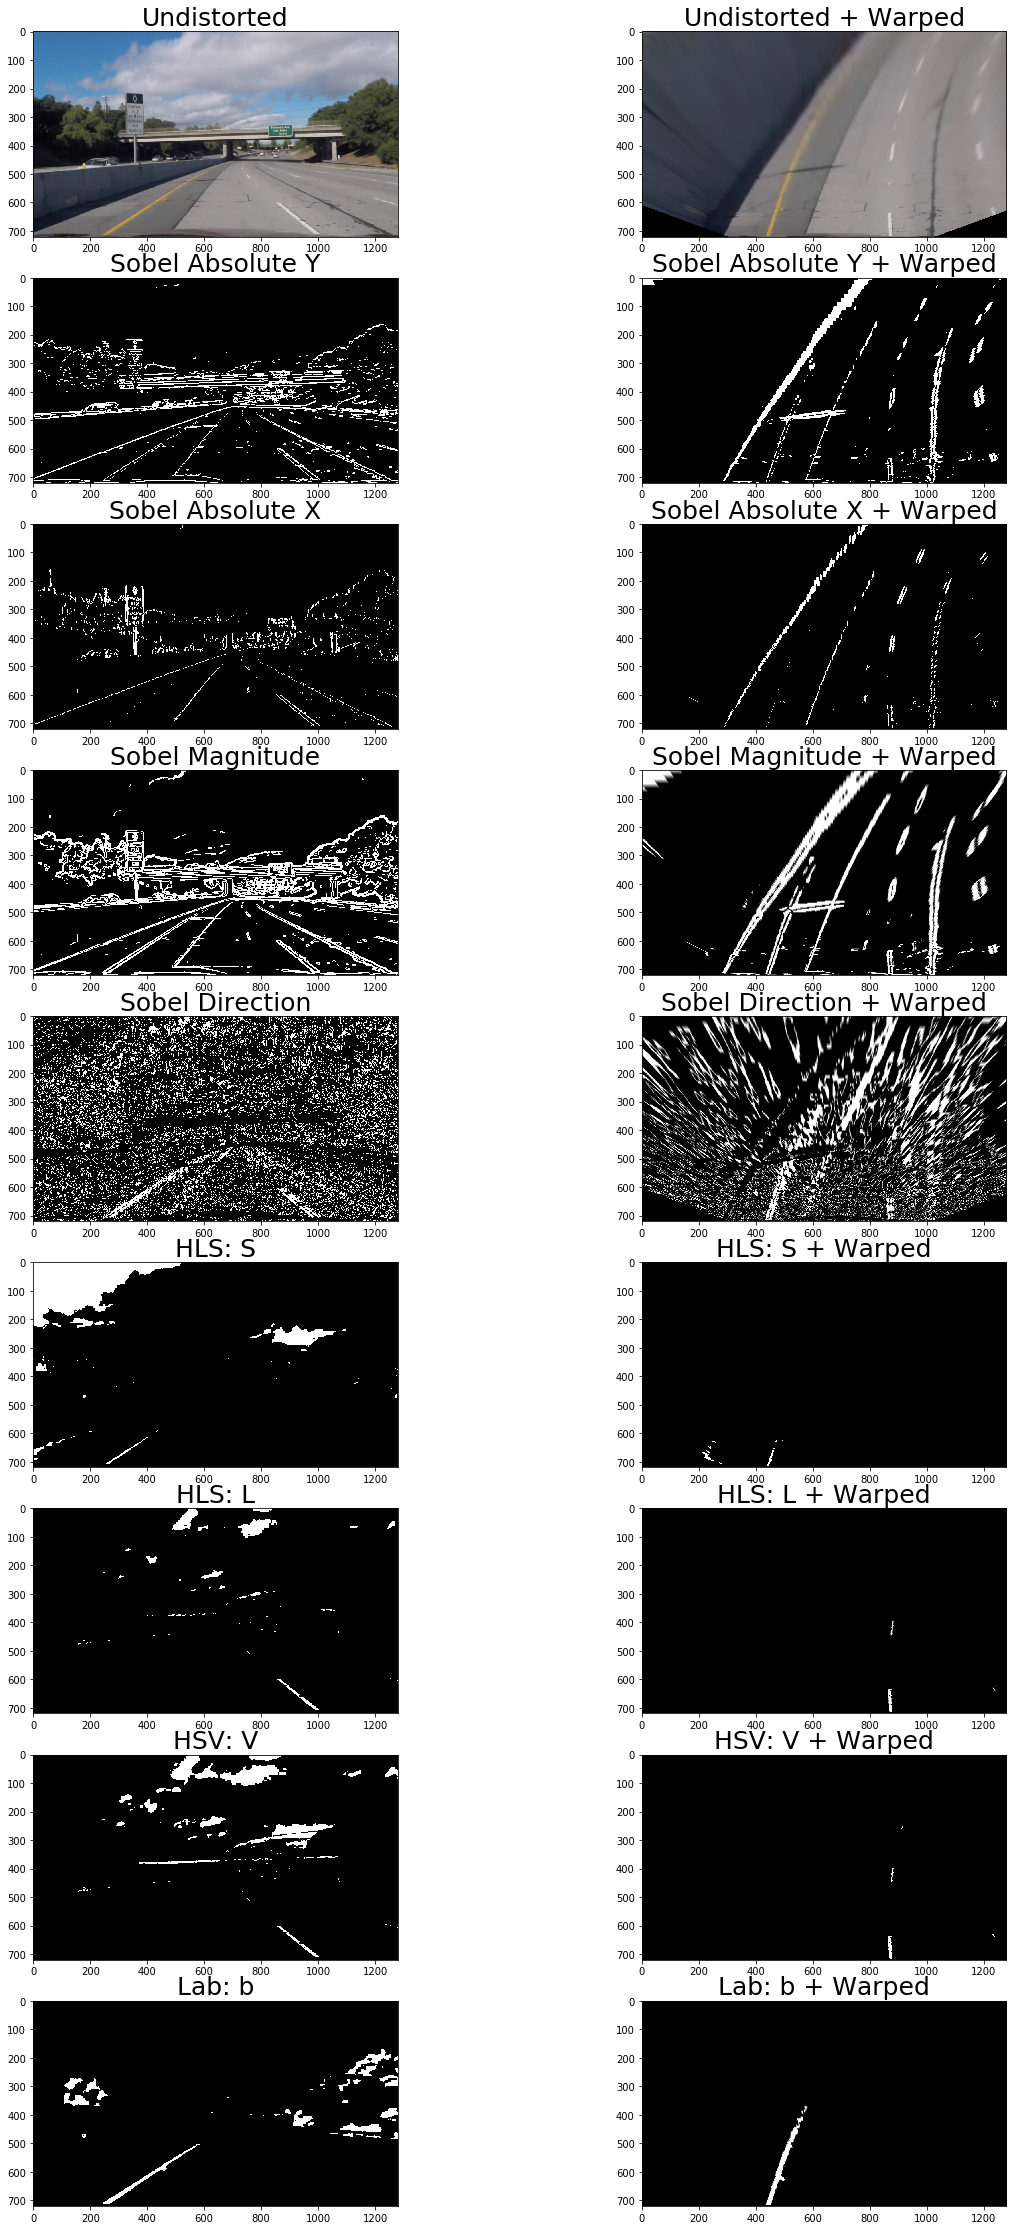

In [8]:
# To begin with, I do not know which operation/ color space conversion best exracts the pixels corresponding to the lane lines.
# So I get transformation from all of the following function..

#first take an image
path = 'test_images/'
filenames = os.listdir(path)
fname = path + filenames[0]
img = mpimg.imread(fname)

#Undistort
undst = undistort_image(img, mtx, dist)
undst_warp = warp_image(undst, perp_matrix, flags=cv2.INTER_LINEAR)

# get sobel gradient in Y direction
grad_binary_y = abs_sobel_thresh(undst, orient='y', thresh_min=20, thresh_max=200, sobel_kernel=3)
grad_binary_y_warp = warp_image(grad_binary_y, perp_matrix, flags=cv2.INTER_LINEAR)

# get sobel gradient in X direction
grad_binary_x = abs_sobel_thresh(undst, orient='x', thresh_min=20, thresh_max=200, sobel_kernel=3)
grad_binary_x_warp = warp_image(grad_binary_x, perp_matrix, flags=cv2.INTER_LINEAR)

# get magnitude of sobel gradient 
mag_binary = mag_thresh(undst, sobel_kernel=13, mag_thresh=(20, 100))
mag_binary_warp = warp_image(mag_binary, perp_matrix, flags=cv2.INTER_LINEAR)

# get direction component of sobel operator
dir_binary = dir_threshold(undst, sobel_kernel=15, thresh=(0.7, 1.1))
dir_binary_warp = warp_image(dir_binary, perp_matrix, flags=cv2.INTER_LINEAR)

# get S channel of HLS colorspace
hls_binary_s = hls_select_s(undst, thresh=(100, 255))
hls_binary_s_warp = warp_image(hls_binary_s, perp_matrix, flags=cv2.INTER_LINEAR)

# get L channel of HLS colorspace
hls_binary_l = hls_select_l(undst, thresh=(200, 255))
hls_binary_l_warp = warp_image(hls_binary_l, perp_matrix, flags=cv2.INTER_LINEAR)

# get V channel of HSV colorspace
hsv_binary_v = hsv_select_v(undst, thresh=(200, 255))
hsv_binary_v_warp = warp_image(hsv_binary_v, perp_matrix, flags=cv2.INTER_LINEAR)

# get b channel of Lab colorspace
lab_binary_b = Lab_select_b(undst, thresh=(180, 255))
lab_binary_b_warp = warp_image(lab_binary_b, perp_matrix, flags=cv2.INTER_LINEAR)

#plot all
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16), (ax17, ax18)) = plt.subplots(9, 2, figsize=(20, 40))

ax1.imshow(undst)
ax1.set_title('Undistorted', fontsize=25)
ax2.imshow(undst_warp)
ax2.set_title('Undistorted + Warped', fontsize=25)

ax3.imshow(grad_binary_y, cmap='gray')
ax3.set_title('Sobel Absolute Y', fontsize=25)
ax4.imshow(grad_binary_y_warp,  cmap='gray')
ax4.set_title('Sobel Absolute Y + Warped', fontsize=25)

ax5.imshow(grad_binary_x,  cmap='gray')
ax5.set_title('Sobel Absolute X', fontsize=25)
ax6.imshow(grad_binary_x_warp,  cmap='gray')
ax6.set_title('Sobel Absolute X + Warped', fontsize=25)

ax7.imshow(mag_binary, cmap='gray')
ax7.set_title('Sobel Magnitude', fontsize=25)
ax8.imshow(mag_binary_warp,  cmap='gray')
ax8.set_title('Sobel Magnitude + Warped', fontsize=25)

ax9.imshow(dir_binary,  cmap='gray')
ax9.set_title('Sobel Direction', fontsize=25)
ax10.imshow(dir_binary_warp,  cmap='gray')
ax10.set_title('Sobel Direction + Warped', fontsize=25)

ax11.imshow(hls_binary_s,  cmap='gray')
ax11.set_title('HLS: S', fontsize=25)
ax12.imshow(hls_binary_s_warp,  cmap='gray')
ax12.set_title('HLS: S + Warped', fontsize=25)

ax13.imshow(hls_binary_l,  cmap='gray')
ax13.set_title('HLS: L', fontsize=25)
ax14.imshow(hls_binary_l_warp,  cmap='gray')
ax14.set_title('HLS: L + Warped', fontsize=25)

ax15.imshow(hsv_binary_v,  cmap='gray')
ax15.set_title('HSV: V', fontsize=25)
ax16.imshow(hsv_binary_v_warp,  cmap='gray')
ax16.set_title('HSV: V + Warped', fontsize=25)

ax17.imshow(lab_binary_b,  cmap='gray')
ax17.set_title('Lab: b', fontsize=25)
ax18.imshow(lab_binary_b_warp,  cmap='gray')
ax18.set_title('Lab: b + Warped', fontsize=25)


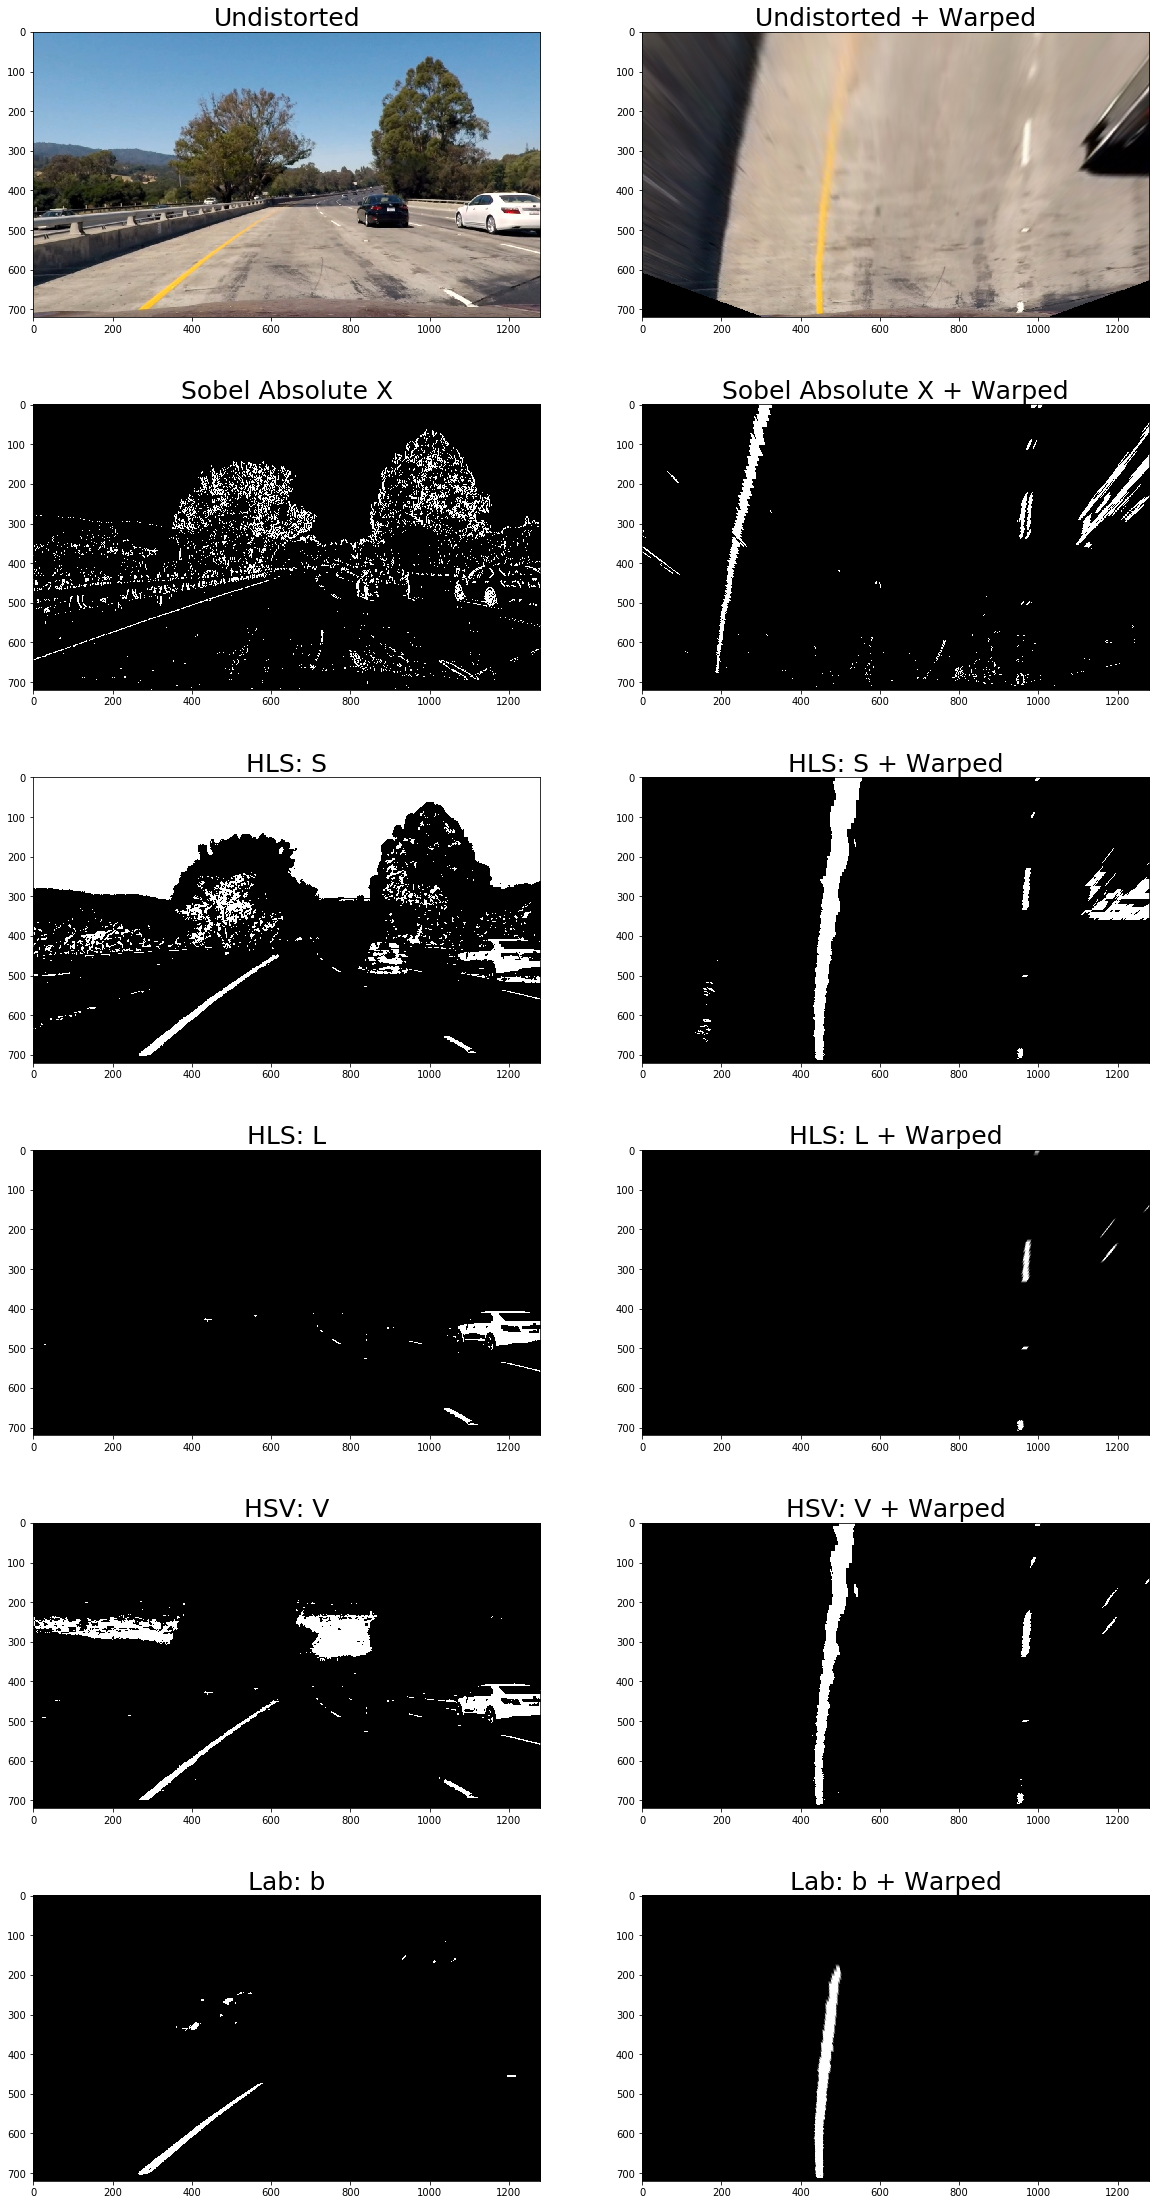

In [9]:
# Verify the above with another image from a different video stream
# looks like sobel operator is not good enough.. so test only the color space options..

#take a different image this time
path = 'test_images/'
filenames = os.listdir(path)
fname = path + filenames[6]
img = mpimg.imread(fname)

undst = undistort_image(img, mtx, dist)
undst_warp = warp_image(undst, perp_matrix, flags=cv2.INTER_LINEAR)

grad_binary_x = abs_sobel_thresh(undst, orient='x', thresh_min=20, thresh_max=200, sobel_kernel=3)
grad_binary_x_warp = warp_image(grad_binary_x, perp_matrix, flags=cv2.INTER_LINEAR)

hls_binary_s = hls_select_s(undst, thresh=(100, 255))
hls_binary_s_warp = warp_image(hls_binary_s, perp_matrix, flags=cv2.INTER_LINEAR)

hls_binary_l = hls_select_l(undst, thresh=(220, 255))
hls_binary_l_warp = warp_image(hls_binary_l, perp_matrix, flags=cv2.INTER_LINEAR)

hsv_binary_v = hsv_select_v(undst, thresh=(220, 255))
hsv_binary_v_warp = warp_image(hsv_binary_v, perp_matrix, flags=cv2.INTER_LINEAR)

lab_binary_b = Lab_select_b(undst, thresh=(190, 255))
lab_binary_b_warp = warp_image(lab_binary_b, perp_matrix, flags=cv2.INTER_LINEAR)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6, 2, figsize=(20, 40))
#f.tight_layout()

ax1.imshow(undst)
ax1.set_title('Undistorted', fontsize=25)
ax2.imshow(undst_warp)
ax2.set_title('Undistorted + Warped', fontsize=25)

ax3.imshow(grad_binary_x,  cmap='gray')
ax3.set_title('Sobel Absolute X', fontsize=25)
ax4.imshow(grad_binary_x_warp,  cmap='gray')
ax4.set_title('Sobel Absolute X + Warped', fontsize=25)

ax5.imshow(hls_binary_s,  cmap='gray')
ax5.set_title('HLS: S', fontsize=25)
ax6.imshow(hls_binary_s_warp,  cmap='gray')
ax6.set_title('HLS: S + Warped', fontsize=25)

ax7.imshow(hls_binary_l,  cmap='gray')
ax7.set_title('HLS: L', fontsize=25)
ax8.imshow(hls_binary_l_warp,  cmap='gray')
ax8.set_title('HLS: L + Warped', fontsize=25)

ax9.imshow(hsv_binary_v,  cmap='gray')
ax9.set_title('HSV: V', fontsize=25)
ax10.imshow(hsv_binary_v_warp,  cmap='gray')
ax10.set_title('HSV: V + Warped', fontsize=25)

ax11.imshow(lab_binary_b,  cmap='gray')
ax11.set_title('Lab: b', fontsize=25)
ax12.imshow(lab_binary_b_warp,  cmap='gray')
ax12.set_title('Lab: b + Warped', fontsize=25)


In [10]:
#ok, now define the pipeline. As per the obervation above, L channel of HLS and b channel of Lab are feasible options. 
def pipeline(img):
    # Undistort
    undst = undistort_image(img, mtx, dist)
    
    #get L channel HLS color space
    hls_binary_l =  hls_select_l(undst, thresh=(210, 255))
    hls_binary_l_warp = warp_image(hls_binary_l, perp_matrix, flags=cv2.INTER_LINEAR)
    
    #get b channel of Lab color space
    lab_binary_b = Lab_select_b(undst, thresh=(190, 255))
    lab_binary_b_warp = warp_image(lab_binary_b, perp_matrix, flags=cv2.INTER_LINEAR)
    
    #combine them
    combined = np.zeros_like(hls_binary_l_warp)
    combined[(hls_binary_l_warp == 1) | (lab_binary_b_warp == 1)] = 1
    
    return combined



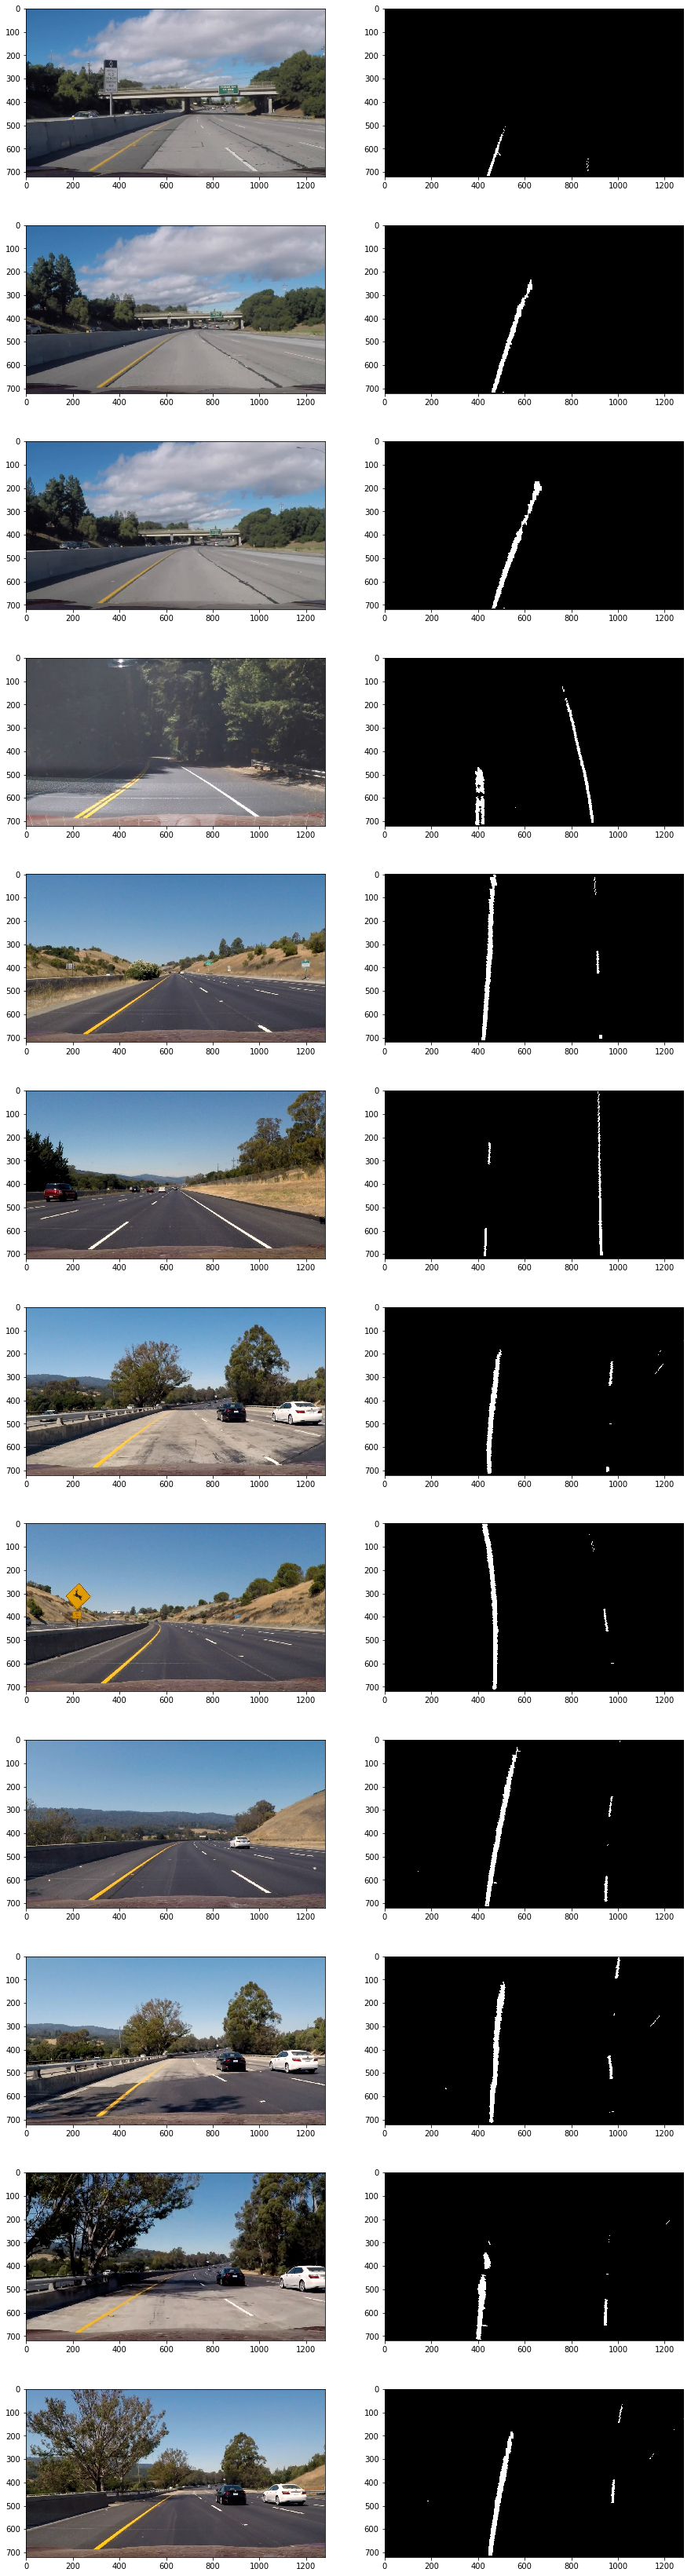

In [11]:
# Now test all images with the pipeline described above.

path = 'test_images/'
filenames = os.listdir(path)
fig, axs = plt.subplots(len(filenames),2, figsize=(15, 60))
axs = axs.ravel()
k = 0
for i in range(len(filenames)):
    fname = path + filenames[i]
    img = mpimg.imread(fname)
    img_bin  = pipeline(img)
    axs[k].imshow(img)
    k += 1
    axs[k].imshow(img_bin, cmap='gray')
    k += 1


In [12]:
# Method to fit polynomial using sliding window approach

#the following code is taken from the lecture notes
def polyfit_using_sliding_window(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
       
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []
        
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
                
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    ractangle_and_histogram = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, ractangle_and_histogram

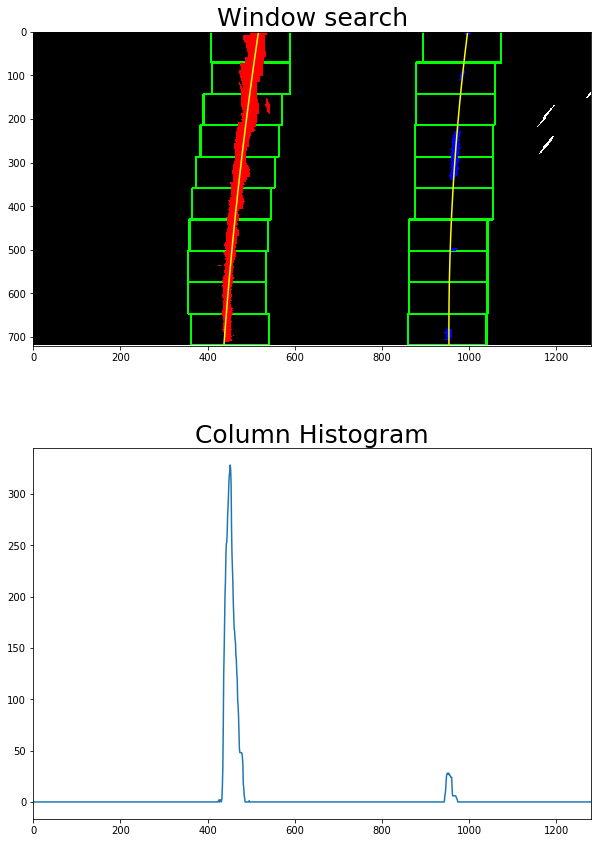

In [13]:
#visualize the polyfit lines using an example binary imge
#lets take HSV-V channel as the binary thresholded image
binary_warped = hsv_binary_v_warp 
left_fit, right_fit, left_lane_inds, right_lane_inds, ractangle_and_histogram = polyfit_using_sliding_window(binary_warped)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

#variables to get rectuangles and histograms for visualization
rectangles = ractangle_and_histogram[0]
histogram = ractangle_and_histogram[1]

for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(10, 15))

ax1.imshow(out_img)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.set_xlim([0, 1280])
ax1.set_ylim([720, 0])
ax1.set_title('Window search', fontsize=25)

ax2.plot(histogram)
ax2.set_xlim([0, 1280])
ax2.set_title('Column Histogram', fontsize=25)


In [14]:
# Method to fit the polynomial using the previous fit

#the following code is taken from the lecture notes

def polyfit_using_previous_fit(binary_warped, left_fit, right_fit, margin):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds

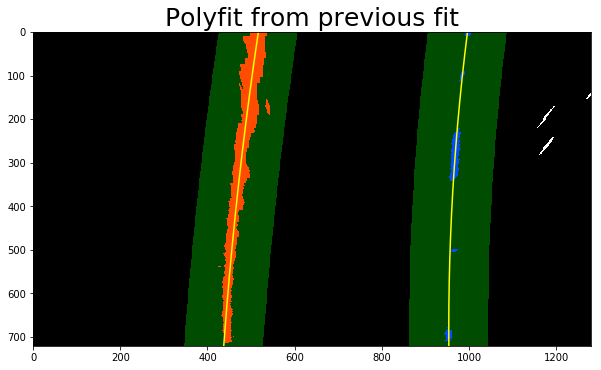

In [15]:
#visualize the polyfit lines using an example binary imge
#lets take HSV-V channel as the binary thresholded image
binary_warped = hsv_binary_v_warp
margin = 90

left_fit_new, right_fit_new, left_lane_inds, right_lane_inds = polyfit_using_previous_fit(binary_warped, left_fit, right_fit, margin)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

f, (ax1) = plt.subplots(1, 1, figsize=(10, 15))
ax1.imshow(result)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.set_xlim([0, 1280])
ax1.set_ylim([720, 0])
ax1.set_title('Polyfit from previous fit', fontsize=25)

In [16]:
#method to compute the radius of vurvature
def compute_CurvRadius_centerOffset(binary_warped, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    img_height = binary_warped.shape[0]
    ploty = np.linspace(0, img_height-1, img_height)# to cover same y-range as image
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curverad = 0
    right_curverad = 0
    offset_from_center_dist = 0
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
    # Distance from center is image midpoint in x - mean of l_fit and r_fit intercepts 
    if l_fit is not None and r_fit is not None:
        image_midpoint = binary_warped.shape[1]//2
        l_fit_x_int = l_fit[0]*img_height**2 + l_fit[1]*img_height + l_fit[2]
        r_fit_x_int = r_fit[0]*img_height**2 + r_fit[1]*img_height + r_fit[2]
        lane_midpoint = (r_fit_x_int + l_fit_x_int) //2
        offset_from_center_dist = (image_midpoint - lane_midpoint) * xm_per_pix #in meters
        
    return left_curverad, right_curverad, offset_from_center_dist

#method to draw lane line on the original image, along with some track information
def drawing_lane(original_img, binary_warped, l_fit, r_fit, Minv, left_radius, right_radius, offset_center):
    
    if l_fit is None or r_fit is None:
        return original_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    image_height,image_width = binary_warped.shape
    ploty = np.linspace(0, image_height-1, image_height) # to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_width, image_height)) 
    # Combine the result with the original image
    with_lane = cv2.addWeighted(original_img, 1, newwarp, 0.5, 0)
        
    font = cv2.FONT_HERSHEY_SIMPLEX 
    text = 'Left curve radius : ' + '{:04.2f}'.format(left_radius) + 'm'
    cv2.putText(with_lane, text, (30,60), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    text = 'Right curve radius: ' + '{:04.2f}'.format(right_radius) + 'm'
    cv2.putText(with_lane, text, (30,110), font, 1.5, (255,255,255), 2, cv2.LINE_AA)    
    if offset_center > 0:
        side = 'right'
    elif offset_center <= 0:
        side = 'left'
    abs_offset_center = abs(offset_center)
    text = '{:04.3f}'.format(abs_offset_center) + 'm ' + side + ' of center'
    cv2.putText(with_lane, text, (30,160), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return with_lane
    
    

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):  
         # was the line detected in the last iteration?
        self.detected = False     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]  
        self.current_fit = []  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
    
    #function to get the best fit from past estimates
    def get_best_fit(self, fit):
        # If a fit is found, do the following
        if fit is not None:   
            
            #if there is a best fit available, get the difference of polynomial coefficients to see how much they differ
            if self.best_fit is not None:                
                self.diffs = abs(fit-self.best_fit)      
            
            #if they differ too much, then the latest fit must be erroneous. Discard it. Don't store. And do the following..
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.):   
                
                #if there are more than two previous estimates available, get their average as the best fit
                if len(self.current_fit) >= 2:
                    self.current_fit = self.current_fit[1:]
                    self.best_fit = np.average(self.current_fit, axis=0)
                    self.detected = True 
                    
                #else, start all over again --> (go back to the window search method)
                else:
                    # if there is nothing in the current_fit array
                    self.detected = False     
                    self.best_fit = None
                    self.current_fit = []  
                    self.diffs = np.array([0,0,0], dtype='float')   
                    
            # if the latest fit is closely matching to the best fit, then the latest fit must be valid. Store it. 
            # take the average of past 5 samples as the best fit
            else:                
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # discard the oldest value. update the current_fit list.
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
               
        # if there is no new fit
        else:
            #use the average of past history as the best fit, only if there are more than 2 samples stored.
            if len(self.current_fit) >= 2:
                    self.current_fit = self.current_fit[1:]
                    self.best_fit = np.average(self.current_fit, axis=0)
                    self.detected = True 
            
            #else if the length of stored data is one or less, start all over again --> go back to the window search method
            else:
                # if there is nothing in the current_fit array
                self.detected = False     
                self.best_fit = None
                self.current_fit = []  
                self.diffs = np.array([0,0,0], dtype='float') 
                
            

In [19]:
#THIS IS THE MASTER METHOD THAT PROCESSES IMAGES IN A VIDEO STREAM
def process_image(img):
    new_img = np.copy(img)
    
    #get binary warped image
    img_bin = pipeline(new_img)

    # if you know that left and right fits were available previously, polyfit_using_previous_fit, else go back to the sliding window approach
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = polyfit_using_sliding_window(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_previous_fit(img_bin, l_line.best_fit, r_line.best_fit, margin)
    
    #Do sanity check here
    if l_fit is not None and r_fit is not None:
        
        #get the distance between right lane and left lane at x = img.shape[0]
        h = img.shape[0]
        l_fit_x_top = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_top = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        top_x_dist = abs(l_fit_x_top-r_fit_x_top)
        
        #get the distance between right lane and left lane at x = img.shape[0]-200
        h = img.shape[0]-200
        l_fit_x_bottom = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_bottom = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        bottom_x_dist = abs(l_fit_x_bottom-r_fit_x_bottom)
        
        #the distance between left and right lanes at the closer end of camera must be around 500+/-100 pixels. Else discard the latest fit.
        if abs(top_x_dist-500) > 100:
            l_fit = None
            r_fit = None
            
        #The left and right lanes must be approximately parallel. Else discard the latest fit.    
        if abs(bottom_x_dist-top_x_dist) > 100:
            l_fit = None
            r_fit = None

    #now get the best_fit from current and past records
    l_line.get_best_fit(l_fit)
    r_line.get_best_fit(r_fit)
              
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        rad_l, rad_r, d_center = compute_CurvRadius_centerOffset(img_bin, l_line.best_fit, r_line.best_fit, 
                                                                   l_lane_inds, r_lane_inds)
        img_out = drawing_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, perp_matrix_inv, rad_l, rad_r, d_center)
    else:
        img_out = new_img
       
    return img_out


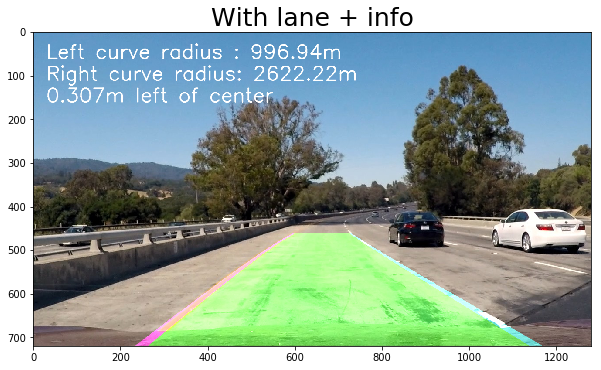

In [25]:
#test an image using the method 'process_image'
path = 'test_images/'
filenames = os.listdir(path)
fname = path + filenames[6]
img = mpimg.imread(fname)

l_line = Line()
r_line = Line()

image_out = process_image(img)

f, (ax1) = plt.subplots(1, 1, figsize=(10, 15))
ax1.imshow(image_out)
ax1.set_title('With lane + info', fontsize=25)

In [21]:
#test project video
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:23<00:00,  2.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 25s


In [22]:
HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(video_output1))

In [23]:
#test challenging video
l_line = Line()
r_line = Line()

video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(0,3)
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [02:57<00:00,  3.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 2min 58s


In [24]:
HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(video_output2))